`THIS NOTEBOOK WAS CREATED BY SOUFIANE` 

- Image preprocessing with openCV
  - Masking
  - Segmentation
  - Reshaping 
  - rescaling 
- Transfer Learning with Keras Pretrained model and Google 
  - VGG19( special layer )
  - VGG19 
  - Mobilnet
- Features Extraction
- Applying deep learning model to classify Images 
- model testing 

## Image preparation

In [73]:
import os 
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import MobileNet
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from shutil import copyfile
from keras.applications import Xception, VGG19, vgg19, xception
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Model, Sequential
from keras.layers import  Dense, Dropout, GlobalAveragePooling2D
#from keras.utils import np_utils, to_categorical
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
import seaborn as sns

In [34]:
data_folder = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/fire_dataset'
train_data_folder = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/fire_dataset/fire_images'
test_date_folder  = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/fire_dataset/non_fire_images'

categories = ['non_fire_images','fire_images']
len_categories = len(categories)

In [35]:

# Définir le répertoire de cache
cache_dir = os.path.expanduser(os.path.join('~', '.keras', 'modeles'))

# Créer le répertoire de cache s'il n'existe pas
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Spécifier le répertoire contenant les modèles locaux
local_models_dir = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/Keras_pretrained_model'

# Copier les modèles locaux dans le répertoire de cache
for file in os.listdir(local_models_dir):
    if file.startswith('vgg'):
        source = os.path.join(local_models_dir, file)
        destination = os.path.join(cache_dir, file)
        copyfile(source, destination)

# Vérifier que les modèles ont été copiés avec succès
print("Modèles copiés avec succès dans le répertoire de cache :", cache_dir)


Modèles copiés avec succès dans le répertoire de cache : /Users/soufianebelhabibe/.keras/modeles


In [36]:
! ls /Users/soufianebelhabibe/.keras/modeles

vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [37]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 163.05it/s]


In [76]:
train_data

[['non_fire_images/non_fire.134.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.120.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.108.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.242.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.47.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.53.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.84.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.90.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.91.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.85.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.52.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.46.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.243.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.109.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.121.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.135.png', 0, 'non_fire_images'],
 ['non_fire_images/non_fire.123.

In [38]:
image_count.keys()

dict_keys(['non_fire_images', 'fire_images'])

In [39]:
print(f"number of fire_images :{len(image_count['fire_images'])}\n number of non_fire_images :{len(image_count['non_fire_images'])} ")

number of fire_images :755
 number of non_fire_images :244 


In [40]:
# create a dataframe 
df = pd.DataFrame(train_data, columns=['file','class','label'])

In [41]:
df.head()

,file,class,label
0,non_fire_images/non_fire.134.png,0,non_fire_images
1,non_fire_images/non_fire.120.png,0,non_fire_images
2,non_fire_images/non_fire.108.png,0,non_fire_images
3,non_fire_images/non_fire.242.png,0,non_fire_images
4,non_fire_images/non_fire.47.png,0,non_fire_images


## Image processing 

In [42]:
# create a mask 
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### Show images

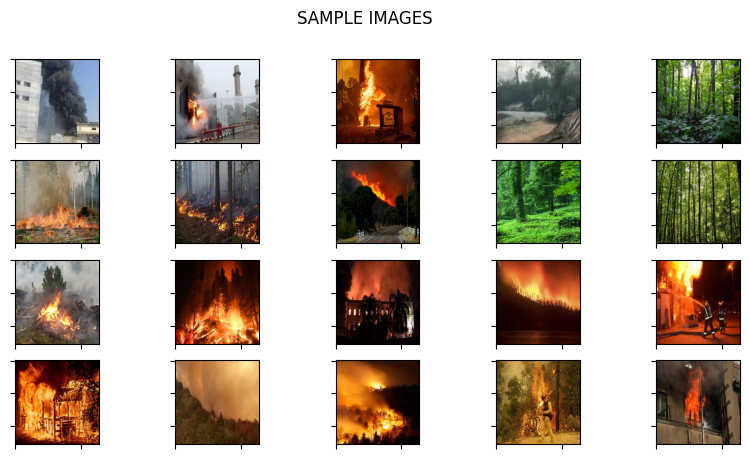

In [16]:
# show image befor processing
nb_rows = 4
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

In [17]:
df['file'][504]

'fire_images/fire.492.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


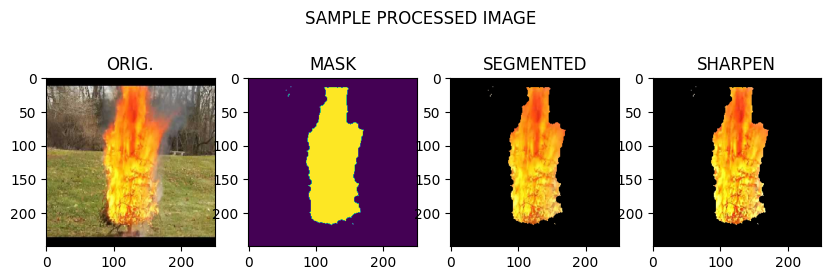

In [18]:
#get an image
img = read_img(df['file'][504],(250,250))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


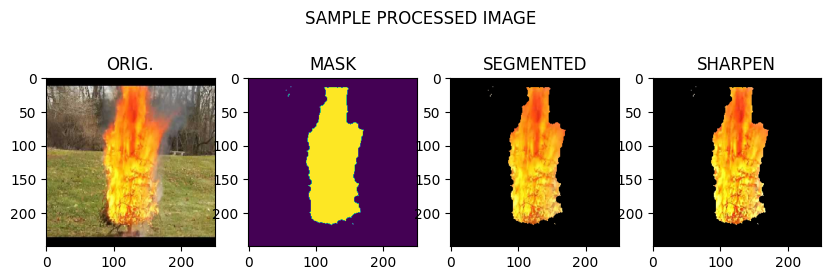

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

## Transfer learning with VGG19
 * [Documentation VGG16 and VGG19](https://keras.io/api/applications/vgg/#vgg19-function)

In [75]:
df

,file,class,label
0,non_fire_images/non_fire.134.png,0,non_fire_images
1,non_fire_images/non_fire.120.png,0,non_fire_images
2,non_fire_images/non_fire.108.png,0,non_fire_images
3,non_fire_images/non_fire.242.png,0,non_fire_images
4,non_fire_images/non_fire.47.png,0,non_fire_images
...,...,...,...
994,fire_images/fire.560.png,1,fire_images
995,fire_images/fire.574.png,1,fire_images
996,fire_images/fire.212.png,1,fire_images
997,fire_images/fire.37.png,1,fire_images


In [77]:
INPUT_SIZE = 224  # La taille d'entrée par défaut pour VGG19

# Prétraitement de l'entrée
data = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    # Lire l'image
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    # Segmenter l'image
    image_segmented = segment_image(img)
    # Aiguiser l'image
    image_sharpen = sharpen_image(image_segmented)
    # Prétraiter l'image pour VGG19
    x = vgg19.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    data[i] = x

999it [00:09, 105.52it/s]


In [65]:
print('Train Image Shape: ', data.shape)
print('Train Image Size: ', data.size)

Train Image Shape:  (999, 224, 224, 3)
Train Image Size:  150377472


In [78]:
#data spliting 
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

In [79]:

print(f" x_train shape {X_train.shape}")
print(f" x_test shape {X_test.shape}")
print(f" x_val shape {X_val.shape}")
print(f" y_val shape {X_val.shape}")
print(f" y_train shape {y_train.shape}")
print(f" y_test shape {y_test.shape}")

 x_train shape (639, 224, 224, 3)
 x_test shape (200, 224, 224, 3)
 x_val shape (160, 224, 224, 3)
 y_val shape (160,)
 y_train shape (639,)
 y_test shape (200,)


In [68]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])

FIRE IMAGES ON TRAINING DATA:  488
NON-FIRE IMAGES ON TRAINING DATA:  151


### build a layer for our classification problem and turn of the Vgg_19 hidden_layers

In [52]:
vgg_19 = vgg19.VGG19(
    include_top=False,# don't include the existant layer classification 
    weights="imagenet",
    input_shape=(224, 224, 3)
   )
for layer in vgg_19.layers : 
    layer.trainable = False

# add the layer classification to our fire classification

x = vgg_19.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
# Créer un modèle basé sur le modèle VGG19 avec la nouvelle couche de classification
vgg_model = Model(inputs=vgg_19.input, outputs=prediction)

In [53]:
#keras Sequential model
model = Sequential()
model.add(vgg_model)
# Ajouter des couches supplémentaires
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Ajouter une couche de dropout pour réduire le surajustement
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer = 'adam' , 
    loss = 'binary_crossentropy' ,
      metrics = ['accuracy'])

#model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.7503 - loss: 0.5656 - val_accuracy: 0.7375 - val_loss: 0.5815
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.7621 - loss: 0.5500 - val_accuracy: 0.7375 - val_loss: 0.5812
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.7838 - loss: 0.5220 - val_accuracy: 0.7375 - val_loss: 0.5809
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 147s 7s/step - accuracy: 0.7640 - loss: 0.5472 - val_accuracy: 0.7375 - val_loss: 0.5803
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 8s/step - accuracy: 0.7757 - loss: 0.5323 - val_accuracy: 0.7375 - val_loss: 0.5800
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.7624 - loss: 0.5489 - val_accuracy: 0.7375 - val_loss: 0.5797
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.7637 - loss: 0.5472 - val_accuracy: 0.7375 - val_loss: 0.5795
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - accuracy: 0.7552 - loss: 0.5576 - val_accuracy: 0.7375 - v

Deep learning model

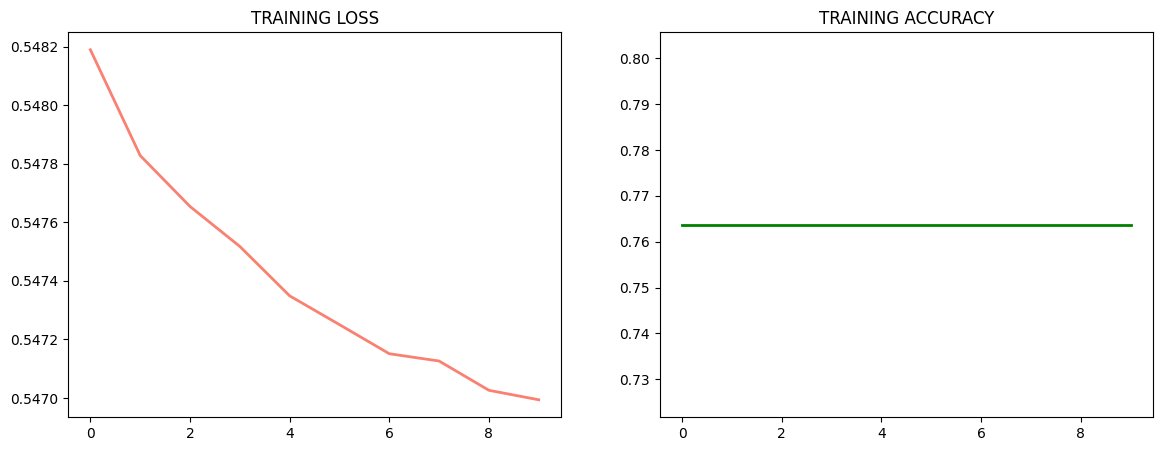

In [54]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')


ax[0].plot(history.history['loss'], color= 'salmon',lw=2)
ax[1].plot(history.history['accuracy'], color= 'green',lw=2)

we can see that our model does not realy performed the classification because we putted of the layers of keras pretrained model

### Use the pretrained model with his layers

In [69]:
Vgg_19 = VGG19(
    include_top=True,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling ="avg", 
    classes =1000
)

In [ ]:
#keras Sequential model_VGG_19
model_VGG_19 = Sequential()
# Ajouter la base VGG-19
model_VGG_19.add(Vgg_19)

# Ajouter des couches supplémentaires
model_VGG_19.add(Flatten())
model_VGG_19.add(Dense(256, activation='relu'))
model_VGG_19.add(Dropout(0.5))  # Ajouter une couche de dropout pour réduire le surajustement
model_VGG_19.add(Dense(128, activation='relu'))

# Couche de sortie
model_VGG_19.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_VGG_19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model_VGG_19.summary()
history = model_VGG_19.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model_VGG_19.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')

ax[0].plot(history.history['loss'], color= 'salmon',lw=2)
ax[1].plot(history.history['accuracy'], color= 'green',lw=2)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model testing 

In [31]:

img_path = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/image/fire.jpeg'
INPUT_SIZE = 224
img = image.load_img(img_path, target_size=(INPUT_SIZE, INPUT_SIZE))  
img_array = image.img_to_array(img)

image_segmented = segment_image(img_array)
image_sharpen = sharpen_image(image_segmented)

# Prétraiter l'image pour VGG19
x = vgg19.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))

prediction = model_VGG_19.predict(x)
print(prediction)
if prediction > 0.50 : 
    print("FIRE_IMG")
else : 
    print("NOT FIRE_IMG")    



## Transfer learning with mobilnet
 * [mobilnet documentation](https://keras.io/api/applications/mobilenet/)

In [94]:
import keras
INPUT_SIZE = 224  # La taille d'entrée par défaut pour VGG19

# Prétraitement de l'entrée
data = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    # Lire l'image
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    # Segmenter l'image
    image_segmented = segment_image(img)
    # Aiguiser l'image
    image_sharpen = sharpen_image(image_segmented)
    # Prétraiter l'image pour VGG19
    x = keras.applications.mobilenet.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    data[i] = x

999it [00:09, 101.04it/s]


In [95]:
#data spliting 
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
print(f" x_train shape {X_train.shape}")
print(f" x_test shape {X_test.shape}")
print(f" x_val shape {X_val.shape}")
print(f" y_val shape {y_val.shape}")
print(f" y_train shape {y_train.shape}")
print(f" y_test shape {y_test.shape}")

 x_train shape (639, 224, 224, 3)
 x_test shape (200, 224, 224, 3)
 x_val shape (160, 224, 224, 3)
 y_val shape (160,)
 y_train shape (639,)
 y_test shape (200,)


In [96]:

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_mobilnet = Sequential()
model_mobilnet.add(base_model)
# Ajouter une couche de Global Average Pooling 2D
model_mobilnet.add(GlobalAveragePooling2D())
model_mobilnet.add(Dense(256, activation='relu'))

# Couche de sortie
model_mobilnet.add(Dense(1, activation='sigmoid'))

# Geler les poids de la base MobileNet
base_model.trainable = False

# Compiler le modèle
model_mobilnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle
#model_mobilnet.summary()
# Geler les poids de la base MobileNet
base_model.trainable = False

# Compiler le modèle
model_mobilnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.7163 - loss: 0.5792 - val_accuracy: 0.7375 - val_loss: 0.5593
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.7591 - loss: 0.5218 - val_accuracy: 0.7375 - val_loss: 0.6108
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - accuracy: 0.7845 - loss: 0.4717 - val_accuracy: 0.7375 - val_loss: 0.5342
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.7441 - loss: 0.4999 - val_accuracy: 0.7437 - val_loss: 0.4757
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.7943 - loss: 0.4328 - val_accuracy: 0.7625 - val_loss: 0.4578
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - accuracy: 0.7780 - loss: 0.4325 - val_accuracy: 0.7563 - val_loss: 0.4414
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.8274 - loss: 0.3907 - val_accuracy: 0.7500 - val_loss: 0.4502
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.8069 - loss: 0.3645 - val_accuracy: 0.

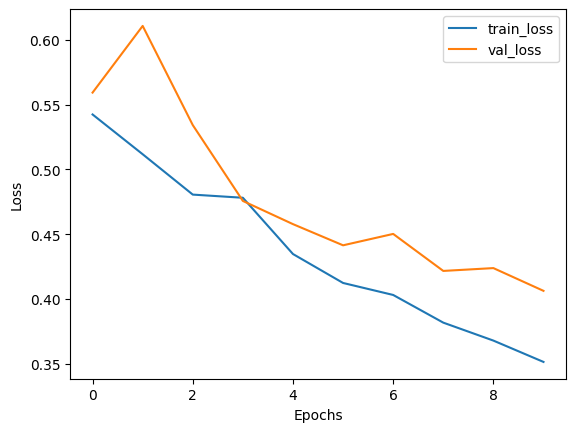

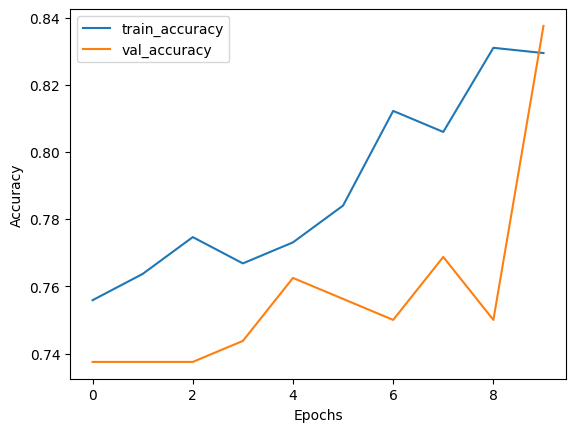

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.8623 - loss: 0.3947
Test loss: 0.39040207862854004
Test accuracy: 0.8700000047683716


In [97]:
# Fit du modèle
history = model_mobilnet.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Évaluation sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step


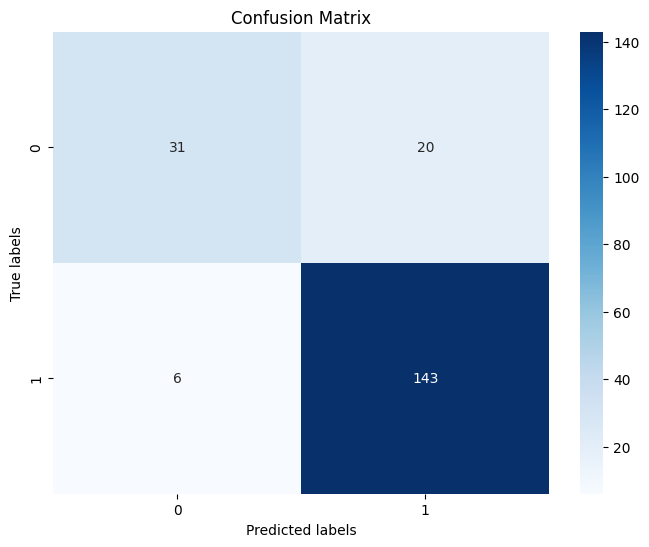

In [102]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Conversion des probabilités en classes binaires

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The mobilNet pretrained model gives us the best result 

### Model testing

In [115]:

img_path = '/Users/soufianebelhabibe/Desktop/Fire-detection-computer-vision-/data/image/feu.webp'
INPUT_SIZE = 224
img = image.load_img(img_path, target_size=(INPUT_SIZE, INPUT_SIZE))  
img_array = image.img_to_array(img)

image_segmented = segment_image(img_array)
image_sharpen = sharpen_image(image_segmented)

# Prétraiter l'image pour mobilnet
x = keras.applications.mobilenet.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))

prediction = model_mobilnet.predict(x)
print(prediction)
if prediction > 0.50 : 
    print("FIRE_IMG")
else : 
    print("NOT FIRE_IMG")  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[[0.49874958]]
NOT FIRE_IMG


## Transfer learning with xception
 * [Xception documentation](https://keras.io/api/applications/xception/)

In [57]:
INPUT_SIZE = 229 # La taille d'entrée par défaut pour xception, vous pouvez voir tous les parametre sur lien que j'ai mentionné en dessous.

# Prétraitement de l'entrée
data = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    # Lire l'image
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    # Segmenter l'image
    image_segmented = segment_image(img)
    # Aiguiser l'image
    image_sharpen = sharpen_image(image_segmented)
    # Prétraiter l'image pour xception
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    data[i] = x

999it [00:10, 97.95it/s] 


In [58]:
print(f" data shape :{data.shape}")
print(f" data shape :{data.size}")

 data shape :(999, 229, 229, 3)
 data shape :157165677


In [59]:
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
# splited data shape
print(f" X_train shape {X_train.shape}")
print(f" X_test shape {X_test.shape}")
print(f" X_train shape {X_val.shape}")
print(f" X_test shape {y_val.shape}")
print(f" y_train shape {y_train.shape}")
print(f" y_test shape {y_test.shape}")

 X_train shape (639, 229, 229, 3)
 X_test shape (200, 229, 229, 3)
 X_train shape (160, 229, 229, 3)
 X_test shape (160,)
 y_train shape (639,)
 y_test shape (200,)


In [62]:
xcp = xception.Xception(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classes=1000)

In [ ]:
#keras Sequential model
model = Sequential()

model.add(xcp)
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer = 'adam' , 
    loss = 'binary_crossentropy' ,
      metrics = ['accuracy'])

#model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')